In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime
import requests_cache
from datetime import timedelta
import datetime

In [2]:
# #загружаю данные с финама
# s = pd.read_csv('AFLT_170605_210605.csv')
# stock = s.iloc[:, 2:]
# stock.rename({'<DATE>': 'date','<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close',
#           '<VOL>': 'vol'}, axis=1, inplace=True)
# l=[]
# #меняю даты на нужный формат
# for i in range(len(stock.date)):
#     p=str(stock.date[i])
#     oldformat = p
#     datetimeobject = datetime.strptime(oldformat,'%Y%m%d')
#     q=datetimeobject.strftime('%Y-%m-%d')
#     l.append(q)
# ind=pd.DatetimeIndex(l)
# stock.index = ind
# df=stock
# df=df.drop(df.columns[[0, 1]], axis=1)
# df #все данные с акции

stock_name = 'TSLA'

start = datetime.datetime(2017, 6, 1)
end = datetime.datetime(2020, 12, 1)

try:
    expire_after = datetime.timedelta(days=3)
    session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
    data_exchange =  web.DataReader(stock_name, 'yahoo', start, end, session=session)  
except: 
    print('Этих акции на такие даты нет')
    
data_exchange = data_exchange.drop(columns = 'Adj Close')
data_exchange.columns = ['open','high','low','close','vol']
df = data_exchange
df

,open,high,low,close,vol
Date,,,,,
2017-06-01,68.975998,67.458000,68.800003,68.073997,38040000.0
2017-06-02,68.575996,67.185997,67.954002,67.970001,27951000.0
2017-06-05,69.688004,66.842003,67.699997,69.463997,33922000.0
2017-06-06,71.898003,67.994003,68.940002,70.570000,55434000.0
2017-06-07,72.099998,71.028000,71.267998,71.930000,46990000.0
...,...,...,...,...,...
2020-11-24,559.989990,526.200012,540.400024,555.380005,53648500.0
2020-11-25,574.000000,545.369995,550.059998,574.000000,48930200.0
2020-11-27,598.780029,578.450012,581.159973,585.760010,37561100.0


In [3]:
def pivot_tikers(df,col):
    item=[]
    tikers=[]
    data=df[col]
    item.append(data)
    combine=pd.concat(item, axis=1) 
    combine.columns=[stock_name]
    return combine  

In [4]:
#беру открытие
df_open = pivot_tikers(df,'open')
ma_200 = df_open.rolling(45).mean() #пробовала 150 и 200 на двух файлах
ma_50 = df_open.rolling(15).mean()
result=pd.concat([df_open,ma_200,ma_50],axis=1)
result.columns=[stock_name,'ma_200','ma_50']
result #таблица со скользящими и ценами акции по датам

,TSLA,ma_200,ma_50
Date,,,
2017-06-01,68.975998,NaN,NaN
2017-06-02,68.575996,NaN,NaN
2017-06-05,69.688004,NaN,NaN
2017-06-06,71.898003,NaN,NaN
2017-06-07,72.099998,NaN,NaN
...,...,...,...
2020-11-24,559.989990,441.384001,460.422666
2020-11-25,574.000000,444.980668,469.662667
2020-11-27,598.780029,449.409113,480.248002


In [5]:
#заполняю NaN разными числами, чтобы при сравнении строчки не совпадали
rrr = result.copy()
rrr['ma_200'] = rrr['ma_200'].fillna(7)
rrr['ma_50'] = rrr['ma_50'].fillna(9)
rrr 

,TSLA,ma_200,ma_50
Date,,,
2017-06-01,68.975998,7.000000,9.000000
2017-06-02,68.575996,7.000000,9.000000
2017-06-05,69.688004,7.000000,9.000000
2017-06-06,71.898003,7.000000,9.000000
2017-06-07,72.099998,7.000000,9.000000
...,...,...,...
2020-11-24,559.989990,441.384001,460.422666
2020-11-25,574.000000,444.980668,469.662667
2020-11-27,598.780029,449.409113,480.248002


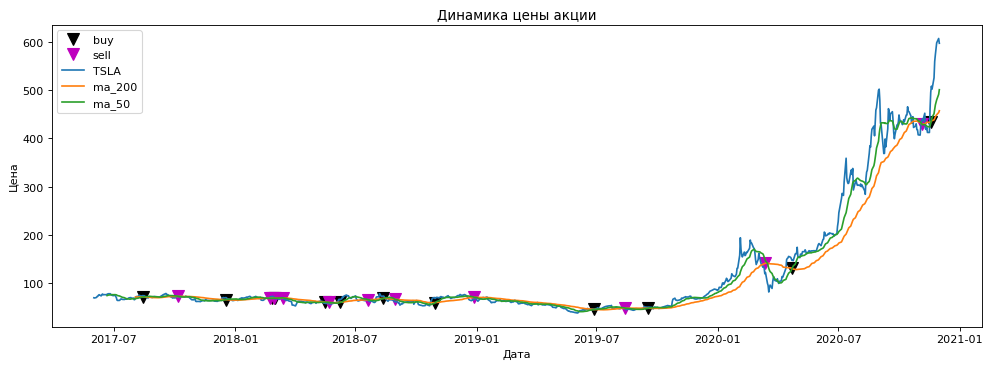

In [6]:
#ищу пересечение
idx = np.argwhere(np.diff(np.sign(rrr["ma_200"] - rrr["ma_50"]))).flatten()
if rrr.iloc[idx[0]][1]==7 or rrr.iloc[idx[0]][2]==9:
    lk = idx[1:]
else:
    lk = idx
lk1 = lk+1 #чтобы покупать и продавать акции на следующий день после пересечения
#разделяем даты на покупку и продажу
lsa = []
for i in range(0, len(lk), 2):
    o = lk[i]
    lsa.append(o)
lsd= []
for i in range(0, len(lk)):
    if i % 2 != 0:
        z =lk[i]
        lsd.append(z)

        
        
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(result.index[lsa], result.loc[result.index[lsa]]['ma_200'],'v', markersize=10, color='k')
plt.plot(result.index[lsd], result.loc[result.index[lsd]]['ma_200'],'v', markersize=10, color='m')
plt.plot(result.index, result.values)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Динамика цены акции')
plt.legend(["buy", "sell", stock_name, "ma_200", "ma_50"])
plt.show()

In [7]:
df_next = pd.DataFrame(df_open[stock_name][result.index[lk1]]) #датафрейм
nextt = df_open[stock_name][result.index[lk1]] #Series
nextt

Date
2017-08-16     73.300003
2017-10-09     70.349998
2017-12-19     68.297997
2018-02-23     70.998001
2018-02-27     71.998001
2018-03-02     67.043999
2018-03-05     67.550003
2018-03-15     66.570000
2018-05-18     56.930000
2018-05-23     55.981998
2018-06-11     66.931999
2018-07-23     61.099998
2018-08-14     71.839996
2018-08-31     61.062000
2018-10-31     68.400002
2018-12-31     67.842003
2019-06-28     45.034000
2019-08-14     46.299999
2019-09-19     49.588001
2020-03-16     98.973999
2020-04-23    146.800003
2020-11-06    436.570007
2020-11-19    508.609985
Name: TSLA, dtype: float64

In [8]:
#работа со стоп-лоссом
stoploss = 0.1
seriestake = df_open[stock_name][result.index[:]] 
seriq = pd.Series(nextt.iloc[[0]])
if len(nextt) % 2 ==0:
    for j in range(len(lk1)):
        if j % 2 ==0:
            for i in range(len(seriestake)-1):
                if (i > lk1[j] and df_open[stock_name][result.index[i]] < df_open[stock_name][result.index[lk1[j]]]*(1-stoploss) and i<lk1[j+1] and seriestake.iloc[[i]][0]>nextt[j+1]):
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[i]])
                    break
                elif i == lk1[j+1]:
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[lk1[j+1]]])
else:
    for j in range(len(lk1)):
        if (j % 2 ==0 and j != len(lk1)-1):
            for i in range(len(seriestake)-1):
                if (i > lk1[j] and df_open[stock_name][result.index[i]] < df_open[stock_name][result.index[lk1[j]]]*(1-stoploss) and i<lk1[j+1] and seriestake.iloc[[i]][0]>nextt[j+1]):
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[i]])
                    break
                elif i == lk1[j+1]:
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[lk1[j+1]]])
        elif j == len(lk1)-1:
            for i in range(len(seriestake)-1):
                if (i > lk1[j] and df_open[stock_name][result.index[i]] < df_open[stock_name][result.index[lk1[j]]]*(1-stoploss)):
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[i]])
                    break  
                elif i == (len(seriestake)-2):
                    seriq = seriq.append(nextt.iloc[[j]])
                    seriq = seriq.append(seriestake.iloc[[len(seriestake)-2]])
seriq      
endd = seriq.iloc[1:]
df_end = pd.DataFrame(endd)
endd #получили новую талицу для дней покупки и продажи - учитывая стоп-лоссы

Date
2017-08-16     73.300003
2017-10-09     70.349998
2017-12-19     68.297997
2018-02-23     70.998001
2018-02-27     71.998001
2018-03-02     67.043999
2018-03-05     67.550003
2018-03-15     66.570000
2018-05-18     56.930000
2018-05-23     55.981998
2018-06-11     66.931999
2018-07-23     61.099998
2018-08-14     71.839996
2018-08-20     61.700001
2018-10-31     68.400002
2018-12-31     67.842003
2019-06-28     45.034000
2019-08-14     46.299999
2019-09-19     49.588001
2020-03-16     98.973999
2020-04-23    146.800003
2020-11-06    436.570007
2020-11-19    508.609985
2020-11-30    607.799988
Name: TSLA, dtype: float64

In [9]:
#считаем доходность с покупки и последующей продажи каждый раз
lissq = []
for i in range(len(endd)-1):
    lllq=(endd[i+1]-endd[i])/ endd[i]*100
    lissq.append(lllq)
for i in range(len(lissq)):
    if i % 2 !=0:
        lissq[i] = lissq[i]*0
lissq
lissq.insert(0,0)
lissq #массив с доходностью

[0,
 -4.024562694156633,
 -0.0,
 3.953270542579805,
 0.0,
 -6.8807498885759575,
 0.0,
 -1.450782106083253,
 -0.0,
 -1.6652061417362725,
 0.0,
 -8.713322180060871,
 0.0,
 -14.114693891768793,
 0.0,
 -0.8157874923664229,
 -0.0,
 2.811206708662727,
 0.0,
 99.59263637592383,
 0.0,
 197.39100698131162,
 0.0,
 19.50217362973004]

In [10]:
#итоговая таблица 
df_end['Buy or Sell'] = ['Buy', 'Sell']*int(len(endd)/2)
df_end['Profit_pc'] = lissq
df_end

,TSLA,Buy or Sell,Profit_pc
Date,,,
2017-08-16,73.300003,Buy,0.000000
2017-10-09,70.349998,Sell,-4.024563
2017-12-19,68.297997,Buy,-0.000000
2018-02-23,70.998001,Sell,3.953271
2018-02-27,71.998001,Buy,0.000000
2018-03-02,67.043999,Sell,-6.880750
2018-03-05,67.550003,Buy,0.000000
2018-03-15,66.570000,Sell,-1.450782
2018-05-18,56.930000,Buy,-0.000000


In [11]:
#Вычисляем прибыль в денежных едеиницах, если каждую акцию покупаем на все деньги
profit_itog=0
for i in range(len(df_end)):
    if i % 2==0:
        get = df_end[stock_name][i+1] - df_end[stock_name][i] 
        profit_itog+=get
profit_itog

415.95000076293945